# 7. Density estimation using normalizing flows

### Authors: [Christopher Lovell](https://www.christopherlovell.co.uk/) and [Natalí S. M. de Santi](https://natalidesanti.github.io/)

## Running options

* **On the fly:** you can easily work with this complete notebook in `google colab`: 

[![Open this notebook in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/natalidesanti/galevo23-tutorials/blob/tutorial_on_halo-galaxy_connection/week-2/tutorial_on_halo-galaxy_connection/Part2%20-%20Normalizing_flows.ipynb)

* **Own computer:** otherwise you can download the notebook in your own computer and work with it in your own space. Just take care with the library dependencies. 

This current notebook contains the $7$th section of the tutorial.

So far we have built a number of supervised machine learning methods for estimating the properties of individual haloes. These are typically fully deterministic - a given set of input features will produce a *single* output value. However, haloes with very similar properties can host very different galaxies, as a result of e.g. their assembly history. 

It would be useful to be able to generate galaxies with a range of *expected* properties, given some conditional input parameters, and in effect marginalise over the unknown parameters that contribute to a given galaxies properties. One method for doing this is using **density estimation**, where the probability density of a given variable is modelled directly. A number of methods can be used to do this, many of which we will hear about over the coming weeks, such as Generative Adversarial Networks (GANs) and Variational Auto Encoders (VAEs). Another method for achieving this is using **Normalizing flows** (NF; see [Sultan's talk last week](https://online.kitp.ucsb.edu/online/galevo23/hassan/) for an example application to HI maps). Normalizing flows allow us to construct very flexible distributions, from which we can sample easily, and also rapidly evaluate the density.

In this short tutorial we will build a simple conditional NF model for the galaxy-halo relationship. This tutorial is based on more detailed ongoing work that will be on the arXiv soon - please reach out if you have any more detailed questions!

You can read more about NF in the following papers: Kobyzev, Prince & Brubaker 2019, [arXiv:1908.09257](https://arxiv.org/abs/1908.09257)

This section is heavily inspired by the [pyro docs on normalizing flows](https://pyro.ai/examples/normalizing_flows_i.html)

![an image](https://miro.medium.com/max/1400/1*wR6mfpyRY5Xbm5EPrLPNUw.webp)

### 7.1 Import PyTorch and Pyro

In [1]:
!pip3 install -q pyro-ppl 
!pip3 install matplotlib==3.6

     |████████████████████████████████| 9.4 MB 4.6 MB/s eta 0:00:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.6.3
    Uninstalling matplotlib-3.6.3:
      Successfully uninstalled matplotlib-3.6.3


In [2]:
import torch
import pyro
import pyro.distributions as dist
import pyro.distributions.transforms as T
import matplotlib.pyplot as plt
import seaborn as sns
import os

import h5py
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
# smoke_test = ('CI' in os.environ)

/home/chris/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 7.2 Some background

Take a multivariate normal distribution $X\sim\mathcal{N}(\mathbf{0},I_{D\times D})$. We can generate samples from a new distribution, $Y$, by passing this through a bijective (reversible) function $g(\cdot)$ (vector valued in the multivaraite case, $g:\mathbb{R}^D\rightarrow\mathbb{R}^D$), in order to produce a new transformed variable $Y=g(X)$. 

![norm flow](https://siboehm.com/assets/img/nfn/normalizing_flow.png)

We will typically want to **sample** from this new variable, and also apply **scoring** in order to evaluate the mapping we have learnt; how does the log density of $X$ relate to $Y$?

Sampling is simple - we first sample $X = x$, then $y=g(x)$.

For scoring, we can use the substitution rule. The expectation value of $X$ is given by

\begin{align}
\mathbb{E}_{p_X(\cdot)}\left[f(X)\right] &= \int_{\text{supp}(X)}f(\mathbf{x})p_X(\mathbf{x})d\mathbf{x}\\
&= \int_{\text{supp}(Y)}f(g^{-1}(\mathbf{y}))p_X(g^{-1}(\mathbf{y}))\det\left|\frac{d\mathbf{x}}{d\mathbf{y}}\right|d\mathbf{y}\\
&= \mathbb{E}_{p_Y(\cdot)}\left[f(g^{-1}(Y))\right],
\end{align}

Because $g$ is bijective we can go apply the substituion rule. Then, equating the last two lines

\begin{align}
\log(p_Y(y)) &= \log(p_X(g^{-1}(y)))+\log\left(\det\left|\frac{d\mathbf{x}}{d\mathbf{y}}\right|\right)\\
&= \log(p_X(g^{-1}(y)))-\log\left(\det\left|\frac{d\mathbf{y}}{d\mathbf{x}}\right|\right).
\end{align}

From the docs: "Inituitively, this equation says that the density of $Y$ is equal to the density at the corresponding point in $X$, plus a term that corrects for the warp in volume around an infinitesimally small length around $Y$ caused by the transformation. For instance, in 2-dimensions, the geometric interpretation of the absolute value of the determinant of a Jacobian is that it represents the area of a parallelogram with edges defined by the columns of the Jacobian. In $n$-dimensions, the geometric interpretation of the absolute value of the determinant Jacobian is that is represents the hyper-volume of a parallelepiped with edges defined by the columns of the Jacobian "

The 'flow' in normalising flows comes from the fact that we can combine these transformation linearly. Say we have transforms $g_{(0)}, g_{(1)},\ldots,g_{(L-1)}$, then the log density of the transformed variable, $Y=(g_{(0)}\circ g_{(1)}\circ\cdots\circ g_{(L-1)})(X)$, is

\begin{align}
\log(p_Y(y)) &= \log\left(p_X\left(\left(g_{(L-1)}^{-1}\circ\cdots\circ g_{(0)}^{-1}\right)\left(y\right)\right)\right)+\sum^{L-1}_{l=0}\log\left(\left|\frac{dg^{-1}_{(l)}(y_{(l)})}{dy'}\right|\right),
%\left( g^{(l)}(y^{(l)})
%\right).
\end{align}

Using this framework, we can transform simple i.i.d normal noise into much more complex distributions. 

### 7.3 A simple NF

Let's start with a simple single layer example of transforming a univariate unit gaussian.

\begin{align}
X &\sim \mathcal{N}(0,1)\\
Y &= \text{exp}(X).
\end{align}

First create our base distribution, `dist_x`, and the transform, `exp_transform`

In [3]:
dist_x = dist.Normal(torch.zeros(1), torch.ones(1))
exp_transform = T.ExpTransform()

We can then create a `TransformedDistribution`, `dist_y`, which takes as argument our base distribution and a list of transformations.

In [4]:
dist_y = dist.TransformedDistribution(dist_x, [exp_transform])

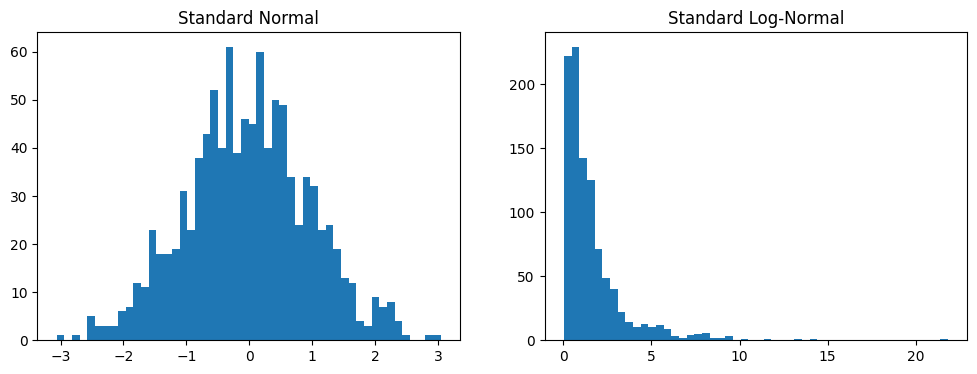

In [5]:
plt.figure(figsize = (12, 4))
plt.subplot(1, 2, 1)
plt.hist(dist_x.sample([1000]).numpy(), bins=50)
plt.title('Standard Normal')
plt.subplot(1, 2, 2)
plt.hist(dist_y.sample([1000]).numpy(), bins=50)
plt.title('Standard Log-Normal')
plt.show()

To model more complex distributions we can compose transforms. Fro example, by combining an exponential with an affinbe transform we can reproduce the general log-normal (in this example with $\mu=3, \sigma=0.5$)

In [6]:
dist_x = dist.Normal(torch.zeros(1), torch.ones(1))
affine_transform = T.AffineTransform(loc=3, scale=0.5)
exp_transform = T.ExpTransform()
dist_y = dist.TransformedDistribution(dist_x, [affine_transform, exp_transform])

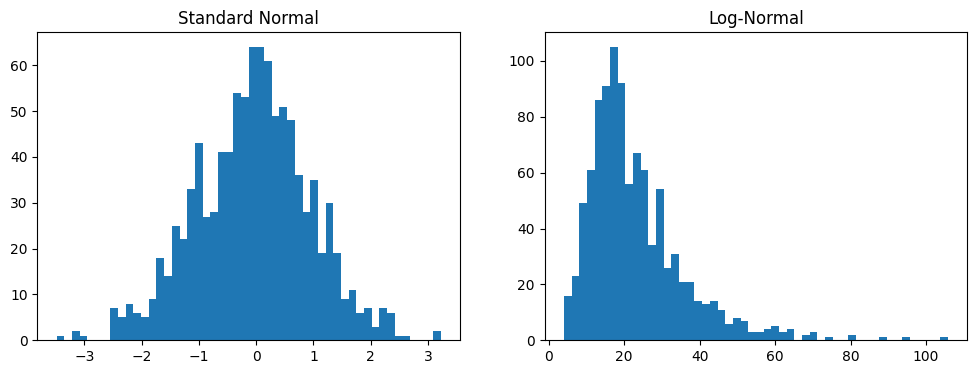

In [7]:
plt.figure(figsize = (12, 4))
plt.subplot(1, 2, 1)
plt.hist(dist_x.sample([1000]).numpy(), bins=50)
plt.title('Standard Normal')
plt.subplot(1, 2, 2)
plt.hist(dist_y.sample([1000]).numpy(), bins=50)
plt.title('Log-Normal')
plt.show()

### 7.4 Multivariate transforms

So far we have considered univariate distributions. In the following we consider multivariate distributions, in particular a simple example of two concentric circles.

In [8]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

In [9]:
n_samples = 1000
X, y = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
X = StandardScaler().fit_transform(X)

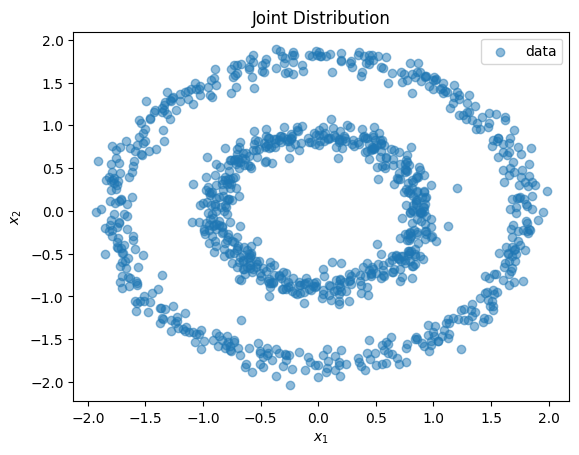

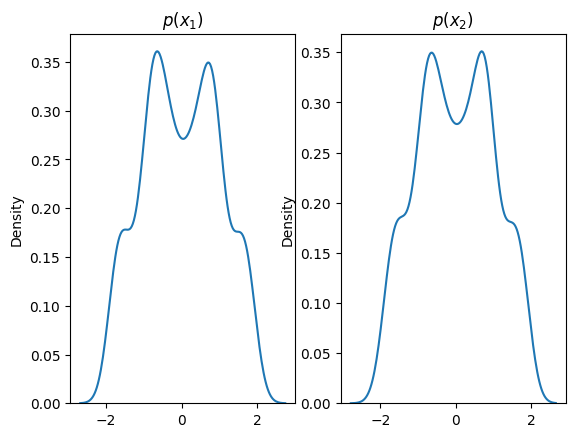

In [10]:
plt.title(r'Joint Distribution')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], label='data', alpha=0.5)
plt.legend()
plt.show()

plt.subplot(1, 2, 1)
sns.kdeplot(X[:,0], label='data')
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.kdeplot(X[:,1], label='data')
plt.title(r'$p(x_2)$')
plt.show()

We can learn the marginals of this distribution using our existing machinery, but this time considering a `Spline` transform (a monotonically increasing function).

In [11]:
base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
spline_transform = T.Spline(2, count_bins = 16)
flow_dist = dist.TransformedDistribution(base_dist, [spline_transform])

To fit this model we use stochastic gradient descent on our maximum likelihood objective function, defined below (don't worry too much about the details here)

In [12]:
steps = 1001
dataset = torch.tensor(X, dtype=torch.float)
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=1e-2)
for step in range(steps):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()

    if step % 200 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 3.308255910873413
step: 200, loss: 1.3205763101577759
step: 400, loss: 1.2632800340652466
step: 600, loss: 1.2602673768997192
step: 800, loss: 1.2579153776168823
step: 1000, loss: 1.2562803030014038


We can now plot samples from our learned flow

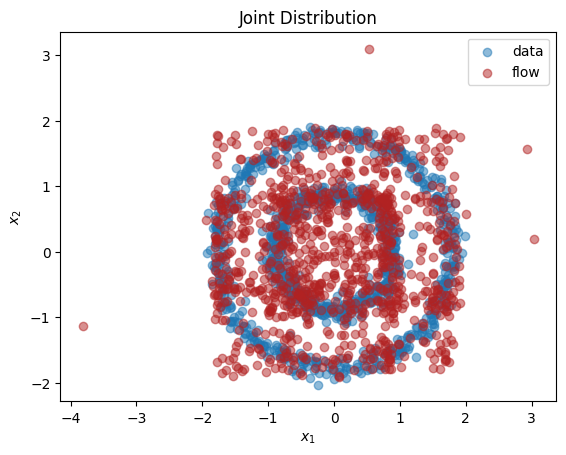

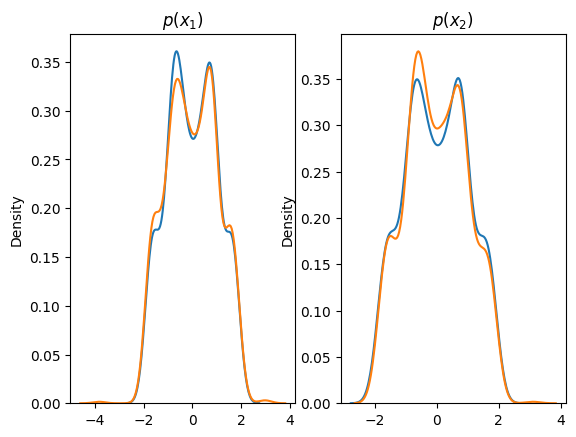

In [13]:
X_flow = flow_dist.sample(torch.Size([1000,])).detach().numpy()
plt.title(r'Joint Distribution')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], label='data', alpha=0.5)
plt.scatter(X_flow[:,0], X_flow[:,1], color='firebrick', label='flow', alpha=0.5)
plt.legend()
plt.show()

plt.subplot(1, 2, 1)
sns.kdeplot(X[:,0], label='data')
sns.kdeplot(X_flow[:,0], label='flow')
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.kdeplot(X[:,1], label='data')
sns.kdeplot(X_flow[:,1], label='flow')
plt.title(r'$p(x_2)$')
plt.show()

It's clear that the marginals have been recovered very well, but the joint distribution has not.

### 7.5 Coupled transforms
To overcome this limitation we now implement coupled transforms. A coupled transform takes the input and divides it into dependent and conditional parts, then applies a bijective transform to the dependent input. 

\begin{align}
\mathbf{y}_{1:d} &= g_\theta(\mathbf{x}_{1:d})\\
\mathbf{y}_{(d+1):D} &= h_\phi(\mathbf{x}_{(d+1):D};\mathbf{x}_{1:d}),
\end{align}

This transform is then invertible in two stages

\begin{align}
\mathbf{x}_{1:d} &= g_\theta^{-1}(\mathbf{y}_{1:d})\\
\mathbf{x}_{(d+1):D} &= h_\phi^{-1}(\mathbf{y}_{(d+1):D};\mathbf{x}_{1:d}).
\end{align}

$g$ and $h$ represent different types of coupling transforms. Introducing different splines between different variables allows the model to represent complex conditional dependence in multivariate distributions.

To demonstrate, we use a `spline_coupling` layer

In [14]:
base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
spline_transform = T.spline_coupling(2, count_bins=16)
flow_dist = dist.TransformedDistribution(base_dist, [spline_transform])

In [15]:
# %%time
steps = 5001
dataset = torch.tensor(X, dtype=torch.float)
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=5e-3)
for step in range(steps+1):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()

    if step % 500 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 4.790243625640869
step: 500, loss: 1.8491681814193726
step: 1000, loss: 1.7838228940963745
step: 1500, loss: 1.6673704385757446
step: 2000, loss: 1.6372486352920532
step: 2500, loss: 1.6377930641174316
step: 3000, loss: 1.6230441331863403
step: 3500, loss: 1.6178661584854126
step: 4000, loss: 1.6535700559616089
step: 4500, loss: 1.6057106256484985
step: 5000, loss: 1.5791895389556885


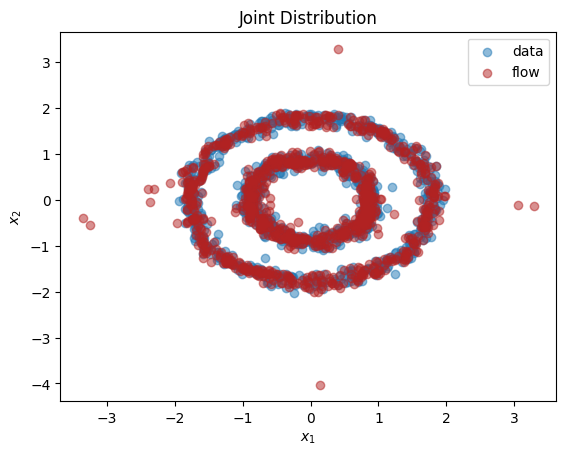

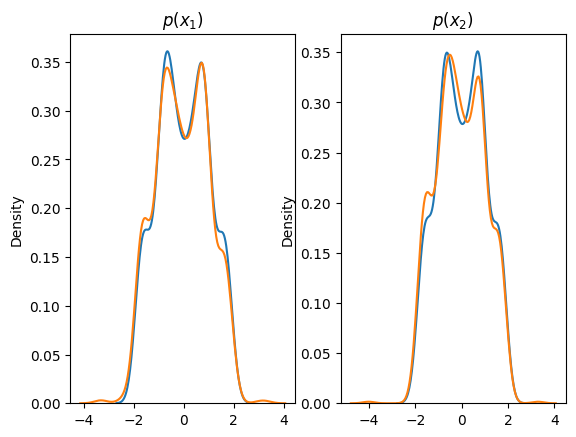

In [16]:
X_flow = flow_dist.sample(torch.Size([1000,])).detach().numpy()
plt.title(r'Joint Distribution')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], label='data', alpha=0.5)
plt.scatter(X_flow[:,0], X_flow[:,1], color='firebrick', label='flow', alpha=0.5)
plt.legend()
plt.show()

plt.subplot(1, 2, 1)
sns.kdeplot(X[:,0], label='data')
sns.kdeplot(X_flow[:,0], label='flow')
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.kdeplot(X[:,1], label='data')
sns.kdeplot(X_flow[:,1], label='flow')
plt.title(r'$p(x_2)$')
plt.show()

Now, not only have re reproduced the marignals but the joint distribution as well.

### 7.6 Conditional transforms

Let's say we wish to produce a density conditional on some other observed parameter, e.g. $p_\theta(\mathbf{x}\mid\mathbf{c})$, where $\mathbf{x}$ is the latent variable, and $\mathbf{c}$ is the context, for some observations $\{(\mathbf{x}_n,\mathbf{c}_n)\}^N_{n=1}$. Normalising flows can readily accommodate these kinds of relationships, such as $Y=g(X;C=\mathbf{c})$.

We will now adapt the example above to produce our joint distribution from the product of a conditional and univariate distribution,

\begin{align}
p(x_1,x_2) &= p(x_2\mid x_1)p(x_1).
\end{align}

First create the univariate distribution.

In [17]:
dist_base = dist.Normal(torch.zeros(1), torch.ones(1))
x1_transform = T.spline(1)
dist_x1 = dist.TransformedDistribution(dist_base, [x1_transform])

`ConditionalTransformedDistribution` initialised with a base distribution and a list of conditional and non-conditional transforms. We also require the dimensions of the context variable, here `context_dim = 1`

In [18]:
x2_transform = T.conditional_spline(1, context_dim=1)
dist_x2_given_x1 = dist.ConditionalTransformedDistribution(dist_base, [x2_transform])

As an example, if the conditional parameter is 1, we can sample given this from the transformed distribution `dist_x2_given_x1`

In [19]:
x1 = torch.ones(1)
print(dist_x2_given_x1.condition(x1).sample())

tensor([-0.8932])


Now, combine and train

In [20]:
# %%time
steps = 5001
modules = torch.nn.ModuleList([x1_transform, x2_transform])
optimizer = torch.optim.Adam(modules.parameters(), lr=3e-3)
x1 = dataset[:,0][:,None]
x2 = dataset[:,1][:,None]
for step in range(steps):
    optimizer.zero_grad()
    ln_p_x1 = dist_x1.log_prob(x1)
    ln_p_x2_given_x1 = dist_x2_given_x1.condition(x1.detach()).log_prob(x2.detach())
    loss = -(ln_p_x1 + ln_p_x2_given_x1).mean()
    loss.backward()
    optimizer.step()
    dist_x1.clear_cache()
    dist_x2_given_x1.clear_cache()

    if step % 500 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 3.8710896968841553
step: 500, loss: 2.02420973777771
step: 1000, loss: 1.91746187210083
step: 1500, loss: 1.852169156074524
step: 2000, loss: 1.820479393005371
step: 2500, loss: 1.9494502544403076
step: 3000, loss: 1.7903977632522583
step: 3500, loss: 1.77792489528656
step: 4000, loss: 1.9032527208328247
step: 4500, loss: 1.7773932218551636
step: 5000, loss: 1.7886521816253662


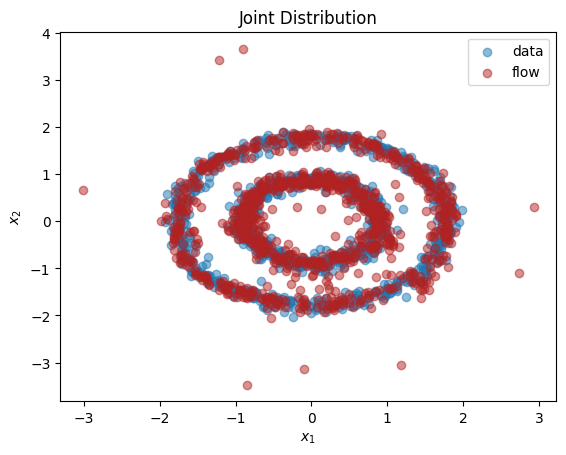

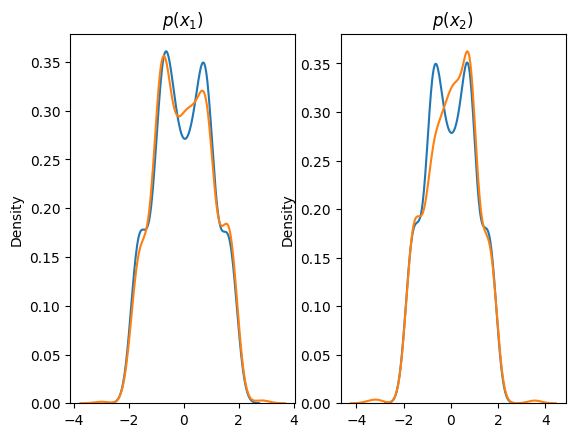

In [21]:
X = torch.cat((x1, x2), dim=-1)
x1_flow = dist_x1.sample(torch.Size([1000,]))
x2_flow = dist_x2_given_x1.condition(x1_flow).sample(torch.Size([1000,]))
X_flow = torch.cat((x1_flow, x2_flow), dim=-1)

plt.title(r'Joint Distribution')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], label='data', alpha=0.5)
plt.scatter(X_flow[:,0], X_flow[:,1], color='firebrick', label='flow', alpha=0.5)
plt.legend()
plt.show()

plt.subplot(1, 2, 1)
sns.kdeplot(X[:,0], label='data')
sns.kdeplot(X_flow[:,0], label='flow')
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.kdeplot(X[:,1], label='data')
sns.kdeplot(X_flow[:,1], label='flow')
plt.title(r'$p(x_2)$')
plt.show()

### 7.7 Using halo data

If you're still with us, we're now going to use this normalizing flow machinery to model the galaxy-halo relationship.

Let's first download and transform some halo and galaxy data.

In [22]:
!wget -q -nc -O DMO-fof_subhalo_tab_033.hdf5 https://www.dropbox.com/s/4iqkimfruqtn8rw/DMO-fof_subhalo_tab_033.hdf5?dl=0
!wget -q -nc -O Nbody_CV_0_IllustrisTNG_CV_0.hdf5 https://www.dropbox.com/s/qhr3ol1bm0vjjvj/Nbody_CV_0_IllustrisTNG_CV_0.hdf5?dl=0
!wget -q -nc -O fof_subhalo_tab_033.hdf5 https://www.dropbox.com/s/fgkxv5w8qr9v54m/fof_subhalo_tab_033.hdf5?dl=0

In [23]:
c = 3.*10**8

with h5py.File('fof_subhalo_tab_033.hdf5', 'r') as f:
    # Positions, velocities and masses of the halos
    M_h =   f['Group/Group_M_Crit200'][:]*1e10      #Msun/h
    R_h =   f['Group/Group_R_Crit200'][:]/c         #kpc/h
    V_h  =  f['Group/GroupVel'][:]                  #km/s
    V_h =   np.linalg.norm(V_h, axis = 1)
    ID_r =  f['Group/GroupFirstSub'][:] #Contains halos without gals as this number = -1
    ID_h =  np.arange(0, M_h.shape[0], 1, dtype = float) #It is the ID of the halos, to match the gal cat

    # Positions, stellar masses,  of the galaxies
    M_g    = f['Subhalo/SubhaloMassType'][:,4]*1e10 #Msun/h
    color_g = f['Subhalo/SubhaloStellarPhotometrics'][:]
    color_g = color_g[:, 4] - color_g[:, 6]
    SFR = f['Subhalo/SubhaloSFR'][:]*1e10 #(Msun/year)/ (10^10 Msun/h)
    ID_g = np.array(f['Subhalo/SubhaloGrNr']) #Gals IDs


# Taking only the halos which have galaxies
indexes = np.where( ID_r != -1)[0]
M_h = M_h[indexes]
R_h = R_h[indexes]
V_h = V_h[indexes]
ID_h = ID_h[indexes]

# Halo catalog
data = np.array( [ M_h, R_h, V_h, ID_h ] ).T
columns = [ 'M_h', 'R_h', 'V_h', 'ID' ] 
halos = pd.DataFrame(data = data, columns = columns)
halos.head(3)

#Galaxy catalog
data = np.array( [ M_g, color_g, SFR, ID_g ] ).T
columns = [ 'M_g', 'color_g', 'SFR_g', 'ID' ] 
gals = pd.DataFrame(data = data, columns = columns)
gals.head(3)

gals = gals.drop_duplicates(subset = ['ID'], keep = 'first')
df = pd.merge(left = halos, right = gals, left_on = 'ID', right_on = 'ID')
df = df[ df['M_g'] > 0 ] #Considering only galaxies [gals are gals if SM > 0]

df['M_h'] = np.log10(df['M_h'])
df['M_g'] = np.log10(df['M_g'])

Here we extract the total halo mass and the galaxy stellar mass. Our aim is going to be to model the joint distribution of these variables, as well as a conditional relation between the halo mass and the galaxy stellar mass.

Below is a plot of the halo mass--stellar mass relation.

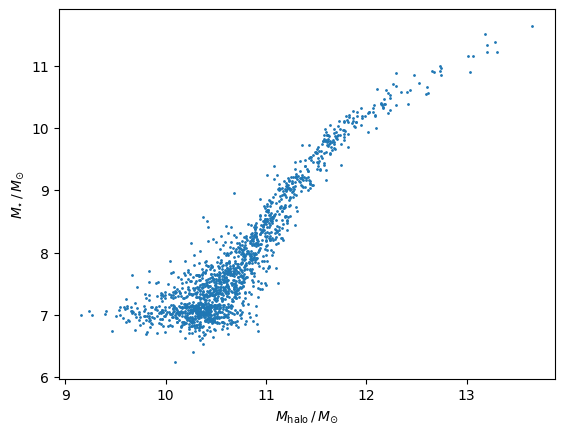

In [24]:
plt.scatter(df['M_h'], df['M_g'], s=1)
plt.xlabel('$M_{\mathrm{halo}} \,/\, M_{\odot}$')
plt.ylabel('$M_{\star} \,/\, M_{\odot}$');

We transform our variables between [-1,1] to help our network learn.

In [25]:
X_scaler = MinMaxScaler(feature_range=(-1., 1.))
Y_scaler = MinMaxScaler(feature_range=(-1., 1.))
halos = X_scaler.fit_transform(df['M_h'][:,None])
gals = Y_scaler.fit_transform(df['M_g'][:,None])

halos = torch.FloatTensor(halos)
gals = torch.FloatTensor(gals)

/tmp/ipykernel_339173/411830487.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  halos = X_scaler.fit_transform(df['M_h'][:,None])
/tmp/ipykernel_339173/411830487.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  gals = Y_scaler.fit_transform(df['M_g'][:,None])


We now build our model. We have to be careful to declare the dimensionality of our feature and conditional arrays. We define our base distribution, our predictor distribution of galaxy properties (`dist_x1`), and our conditional distribution (`dist_x2_given_x1`)

In [26]:
halos_dim = 1
gals_dim = 1

dist_base = dist.Normal(torch.zeros(1), torch.ones(1) * 0.2)
x1_transform = T.spline(halos_dim)
dist_x1 = dist.TransformedDistribution(dist_base, [x1_transform]) 

x2_transform = T.conditional_spline(gals_dim, context_dim=halos_dim)
dist_x2_given_x1 = dist.ConditionalTransformedDistribution(dist_base, [x2_transform])

Now train the model...

In [27]:
steps = 1301
modules = torch.nn.ModuleList([x1_transform, x2_transform])
optimizer = torch.optim.Adam(modules.parameters(), lr=1e-2)

running_loss = 0
for step in range(steps+1):
    optimizer.zero_grad()
    ln_p_x1 = dist_x1.log_prob(halos[:,None])
    ln_p_x2_given_x1 = dist_x2_given_x1.condition(halos[:,None].detach()).log_prob(gals[:,None].detach())
    loss = -(ln_p_x1 + ln_p_x2_given_x1).mean()
    loss.backward()
    optimizer.step()
    dist_x1.clear_cache()
    dist_x2_given_x1.clear_cache()   
    running_loss += 10**loss.item()

Given our trained model, we now need to sample both our distributions back. We first generate a random sample of halos from `dist_x1`, then use these to condition on our galaxy sample from `dist_x2_given_x1`.

Finally, we apply our inverse scaler to get back the un-scaled data (log masses).

In [30]:
halos_flow = dist_x1.sample(torch.Size([int(1e3)]))

gals_flow = dist_x2_given_x1.condition(halos_flow).sample(torch.Size([int(1e3)]))

halos_flow = X_scaler.inverse_transform(halos_flow).flatten()
gals_flow = Y_scaler.inverse_transform(gals_flow).flatten()

Plotting the joint and marginals, we see that everything is repdocued remarkably well.

(6.0, 12.0)

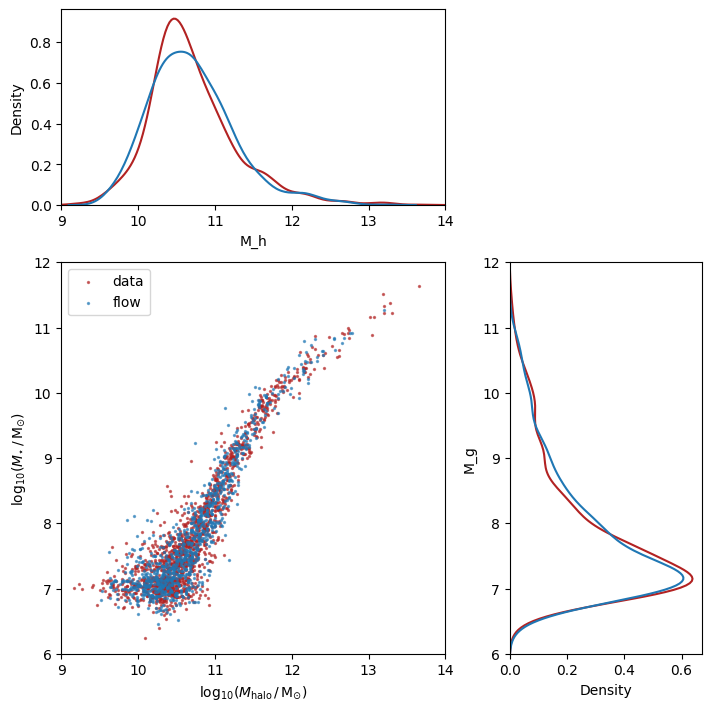

In [31]:
gs_kw = dict(width_ratios=[2, 1], height_ratios=[1, 2])

fig, axd = plt.subplot_mosaic([['upper left', 'upper right'], 
                               ['lower left', 'lower right']],
                              gridspec_kw=gs_kw, figsize=(7, 7), 
                              constrained_layout=True)

xlims = [9, 14]
ylims = [6, 12]

axd['upper right'].remove()
ax = axd['lower left']
ax.scatter(df['M_h'], df['M_g'], s=2, alpha=0.6, label='data', color='firebrick')
ax.scatter(halos_flow, gals_flow, s=2, alpha=0.6, label='flow', color='C0')
ax.set_xlabel('$\mathrm{log_{10}}(M_{\mathrm{halo}} \,/\, \mathrm{M_{\odot}})$')
ax.set_ylabel('$\mathrm{log_{10}}(M_{\star} \,/\, \mathrm{M_{\odot}})$')
ax.set_xlim(xlims); ax.set_ylim(ylims)
ax.legend()

ax = axd['upper left']    
sns.kdeplot(df['M_h'], ax=ax, color='firebrick')
sns.kdeplot(halos_flow, ax=ax, color='C0')
ax.set_xlim(xlims)

ax = axd['lower right']    
sns.kdeplot(y=df['M_g'], ax=ax, color='firebrick')
sns.kdeplot(y=gals_flow, ax=ax, color='C0')
ax.set_ylim(ylims)

This is great, but we're not really using the conditional nature of our flow right now. To make the most of this, we can ask the question, *"what is the expected distribution of stellar masses for a given halo mass?"*

We can answer this by providing specific halo masses to our conditional flow.

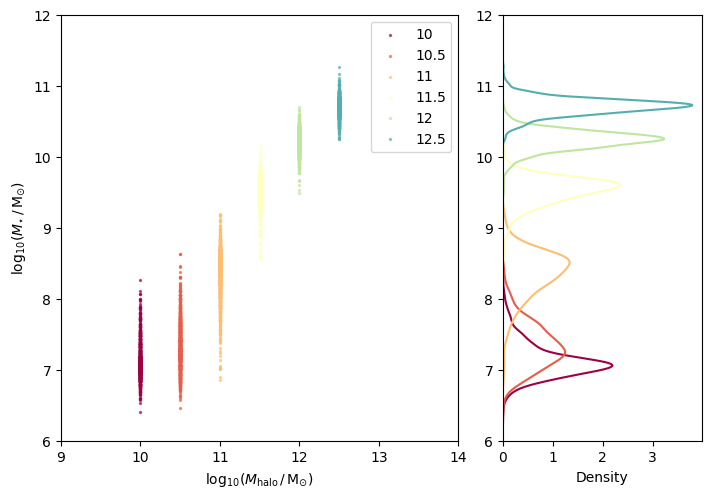

In [32]:
halos_flow = dist_x1.sample(torch.Size([int(1e3)]))#.cpu().detach().numpy()

gs_kw = dict(width_ratios=[2, 1], height_ratios=[1, 2])

fig, axd = plt.subplot_mosaic([['upper left', 'upper right'], 
                               ['lower left', 'lower right']],
                              gridspec_kw=gs_kw, figsize=(7, 7), 
                              constrained_layout=True)

axd['upper right'].remove()
axd['upper left'].remove()
xlims = [9, 14]
ylims = [6, 12]

hmasses = [10, 10.5, 11, 11.5, 12, 12.5]
cmap = plt.cm.get_cmap('Spectral')

for i, hmass in enumerate(hmasses):
    # choose a color from the colormap
    color = cmap(i/len(hmasses))
    
    # generate 1000 halo masses at a given hmass
    halos_flow = torch.Tensor(X_scaler.transform(np.ones(int(1e3))[:,None] * hmass))
    
    # generate galaxies conditioned on this halo mass
    gals_flow = dist_x2_given_x1.condition(halos_flow).sample(torch.Size([int(1e3)])) #.cpu().detach().numpy()

    # apply the scaler inverse
    halos_flow = X_scaler.inverse_transform(halos_flow).flatten()
    gals_flow = Y_scaler.inverse_transform(gals_flow).flatten()

    ax = axd['lower left']
    ax.scatter(halos_flow, gals_flow, s=2, alpha=0.6, label=hmass, color=color)
    ax.set_xlabel('$\mathrm{log_{10}}(M_{\mathrm{halo}} \,/\, \mathrm{M_{\odot}})$')
    ax.set_ylabel('$\mathrm{log_{10}}(M_{\star} \,/\, \mathrm{M_{\odot}})$')
    ax.set_xlim(xlims); ax.set_ylim(ylims)
    ax.legend()

    ax = axd['lower right']
    sns.kdeplot(y=gals_flow, ax=ax, color=color)
    ax.set_ylim(ylims)